In [101]:
import pandas as pd

# Load data
campus_info = pd.read_csv('../../Data/SMTO_2015/Campus_Info.csv')
df = pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Households.csv')[['HmTTS2006', 'hhlivingsituation', 'hhcarnumber','hhnumyoungerthan18','hhnumolderorequalto18','hhincomelevel']]
df = df.join(pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Respondents.csv')[['pscampusattend', 'personstatusgrad', 'personstatustime', 'pscmpgender','psdrivinglicenseownerflag','psworknumhoursperweek']])
df.head()

,HmTTS2006,hhlivingsituation,hhcarnumber,hhnumyoungerthan18,hhnumolderorequalto18,hhincomelevel,pscampusattend,personstatusgrad,personstatustime,pscmpgender,psdrivinglicenseownerflag,psworknumhoursperweek
0,261.0,Live with family/parents,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN
1,71.0,Live with partner,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN
2,3714.0,Live with family/parents,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN
3,74.0,Live with roommates,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN
4,71.0,Live with partner,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN


In [102]:
df = df.rename(columns={'HmTTS2006': 'HomeZone', 'pscampusattend': 'Campus', 'hhlivingsituation': 'Family', 
                       'personstatusgrad': 'Level', 'personstatustime': 'Status', 'psuniversityinvolvednumyears': 'Years', 'hhcarnumber': 'Cars',
                       'hhincomelevel': 'Income', 'pscmpgender': 'Gender', 'psdrivinglicenseownerflag': 'Licence', 'psworknumhoursperweek': 'Work',
                       'hhnumyoungerthan18': 'Children', 'hhnumolderorequalto18':'Adults'})
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [103]:
# Clean and reformat
df = df[df['HomeZone'].notnull()]
df = df[df['Campus'].notnull()]
df['HomeZone'] = pd.to_numeric(df['HomeZone'], downcast='signed')
df['Family'] = (df['Family'] == 'Live with family/parents')*1
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [104]:
df.head()

,HomeZone,Family,Cars,Children,Adults,Income,Campus,Level,Status,Gender,Licence,Work
0,261,1,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN
1,71,0,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN
2,3714,1,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN
3,74,0,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN
4,71,0,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN


In [105]:
def row_to_segment(x):
    if x.Level == 'Other':
        return 0
    elif x.Level == 'UG':
        return 3 if x.Status == 'PT' else (not x.Family) + 1
    else:
        return 6 if x.Status == 'PT' else (4 + (not x.Family))

df['Segment'] = df.apply(row_to_segment, axis=1)

In [106]:
# Dataframe with walk distances
df_path = pd.read_csv('../../../LoS/Walk_Distances.csv')
origins = list(set(list(df_path['Origin'])))
dists = list(df_path['Data'])

# Function for distance lookup
def find_distance(origin, destination):
    try:
        i = origins.index(origin)
    except ValueError:
        return -1
    j = origins.index(destination)
    return dists[i*2392 + j] / 1000

# List of campus' TTS zones from Joven's MOE data
campus_zones = list(campus_info['Zone'])
school_codes = list(campus_info['Code'])

# Load distances into dataframe
for i in range(len(campus_zones)):
    df["Dist." + school_codes[i]] = df['HomeZone'].apply(lambda x: find_distance(x, campus_zones[i]))
df = df[df['Dist.SG'] != -1]
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work', 'Segment', 'Dist.SG',
       'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC'],
      dtype='object')

In [107]:
df.head()

,HomeZone,Family,Cars,Children,Adults,Income,Campus,Level,Status,Gender,Licence,Work,Segment,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC
0,261,1,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN,1,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730
1,71,0,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN,5,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838
2,3714,1,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN,1,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150
3,74,0,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN,2,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276
4,71,0,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN,5,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838


In [136]:
y = df[['Campus','Segment']]
#x = df.drop(columns = ['HomeZone', 'Campus', 'Work'])
x = df[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC','Segment']]
x = pd.get_dummies(x)
x.head()

,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC,Segment
0,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730,1
1,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5
2,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150,1
3,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276,2
4,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5


In [175]:
def mean(lst): 
    return sum(lst) / len(lst) 

import matplotlib.pyplot as plt

accs_mean = []
probs_mean = []

for i in range(6):
    
    accs = []
    probs = []
    
    print("--------------------------- Segment: " + str(i) + " -------------------------------------")
    x_temp = x[x['Segment'] == i]
    x_temp = x_temp[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC']]
    y_temp = y[y['Segment'] == i]
    y_temp = y_temp['Campus']
    
    for j in range(5):    
    
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.3)

        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accs.append(rf.score(X_test, y_test))

        probs = rf.predict_proba(X_test)
        schools = list(rf.classes_)
        results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
        probs = probs + [results.apply(lambda x: x[schools.index(x.Campus)], axis=1).mean()]
        #print(probs)
        #print(probs[1])
    
    accs_mean.append(mean(accs))
    probs_mean.append(mean(probs[1]))
    
    print('Accuracy:', accs_mean[i])
    print('Av. Prob:', probs_mean[i])

--------------------------- Segment: 0 -------------------------------------
[[0.46517568 0.69934234 0.60517568 0.41017568 0.41017568 0.87100901
  0.41017568]
 [0.44017568 0.41017568 0.54017568 0.41017568 0.41017568 1.25017568
  0.41017568]
 [0.55434234 0.41017568 0.41267568 0.41017568 0.41017568 1.26350901
  0.41017568]
 [0.49017568 0.41017568 0.41017568 0.46017568 0.41017568 1.28017568
  0.41017568]
 [0.84284234 0.51017568 0.52350901 0.42017568 0.41017568 0.75417568
  0.41017568]
 [0.95579473 0.41350901 0.41017568 0.41017568 0.42000901 0.85138996
  0.41017568]
 [0.49017568 0.41017568 0.59017568 0.41017568 0.41017568 0.85017568
  0.71017568]
 [1.12469155 0.41017568 0.42017568 0.41017568 0.41017568 0.6856598
  0.41017568]
 [0.64017568 0.41017568 0.42017568 0.42017568 0.41017568 1.16017568
  0.41017568]
 [1.28184234 0.41017568 0.41017568 0.41017568 0.41017568 0.53850901
  0.41017568]
 [0.47517568 0.41017568 0.41017568 0.41017568 0.41017568 1.34517568
  0.41017568]
 [0.48350901 0.4135090

  0.364191  ]]
[0.765691 0.364191 0.364191 0.364191 0.364191 0.942691 0.384191]
[[0.48509507 0.41681729 0.56681729 0.41681729 0.41681729 1.19853952
  0.41681729]
 [0.4770911  0.43110301 0.44681729 0.41681729 0.41681729 1.31225777
  0.41681729]
 [0.49681729 0.60493634 0.44348396 0.41681729 0.41681729 1.12203158
  0.41681729]
 [1.31681729 0.41681729 0.45681729 0.41681729 0.41681729 0.47681729
  0.41681729]
 [0.46681729 0.41681729 0.78681729 0.47681729 0.41681729 0.93681729
  0.41681729]
 [1.36765063 0.41681729 0.42181729 0.41681729 0.41681729 0.46098396
  0.41681729]
 [0.57098396 0.41681729 0.41681729 0.41681729 0.41681729 1.25265063
  0.42681729]
 [1.17513872 0.41681729 0.41681729 0.41681729 0.41681729 0.65849587
  0.41681729]
 [1.04681729 0.41681729 0.41681729 0.45681729 0.44681729 0.71681729
  0.41681729]
 [1.11681729 0.41681729 0.57681729 0.41681729 0.41681729 0.55681729
  0.41681729]
 [0.51681729 0.41681729 0.81681729 0.45681729 0.41681729 0.87681729
  0.41681729]
 [0.87112682 0.416

[[0.37617841 0.35617841 1.30617841 0.35617841 0.35617841 0.38617841
  0.35617841]
 [0.44951174 0.79617841 0.38367841 0.35617841 0.35617841 0.79534507
  0.35617841]
 [0.65817841 0.66617841 0.36367841 0.35617841 0.35617841 0.73217841
  0.36067841]
 [1.13767841 0.35817841 0.36617841 0.35617841 0.35617841 0.56267841
  0.35617841]
 [0.52934507 0.39301174 0.61617841 0.36617841 0.36617841 0.86617841
  0.35617841]
 [0.37617841 0.35617841 0.39617841 0.38617841 0.35617841 1.25617841
  0.36617841]
 [0.47229745 0.40005936 0.44617841 0.89617841 0.35617841 0.56617841
  0.35617841]
 [0.39617841 0.36617841 0.72617841 0.35617841 0.35617841 0.93617841
  0.35617841]
 [0.75444031 0.36777364 0.36617841 0.35617841 0.35617841 0.93632126
  0.35617841]
 [0.61701174 0.57617841 0.36367841 0.35617841 0.35617841 0.86784507
  0.35617841]
 [0.46067841 0.41984507 0.35867841 0.35617841 0.35617841 1.18551174
  0.35617841]
 [0.93617841 0.36617841 0.49951174 0.36617841 0.35617841 0.61284507
  0.35617841]
 [0.83617841 0.3

[[0.62474181 0.38058279 0.25650825 ... 0.25650825 0.4028242  0.48195444]
 [0.45044387 0.25650825 0.33499357 ... 0.3203101  0.4561118  0.25650825]
 [0.76066265 0.25650825 0.58249959 ... 0.25650825 0.25650825 0.25650825]
 ...
 [0.71493682 0.25650825 0.29793682 ... 0.27354793 0.2816273  0.25650825]
 [0.47912719 0.25650825 0.4753404  ... 0.37273838 0.58133867 0.37399661]
 [0.43433179 0.3288292  0.44057256 ... 0.25650825 0.54701165 0.25650825]]
[0.45044387 0.25650825 0.33499357 0.7206819  0.3203101  0.4561118
 0.25650825]
[[0.38501004 0.26552591 0.35770051 ... 0.25687512 0.99223226 0.25973226]
 [0.45079178 0.25487512 0.28820845 ... 0.25598623 0.999764   0.27962512]
 [0.46151797 0.25487512 0.68201004 ... 0.25487512 0.62109734 0.25487512]
 ...
 [0.43974713 0.25487512 0.45085764 ... 0.25487512 0.502006   0.6268897 ]
 [1.025014   0.25487512 0.4761648  ... 0.25487512 0.26344654 0.25487512]
 [0.25487512 0.25487512 0.53485527 ... 0.25487512 0.46725607 0.762514  ]]
[0.45079178 0.25487512 0.28820845

[[1.09457603 0.48983794 0.85176651 ... 0.48983794 0.52317127 0.48983794]
 [1.24983794 0.48983794 0.70983794 ... 0.48983794 0.48983794 0.48983794]
 [1.23883794 0.48983794 0.51483794 ... 0.49983794 0.70583794 0.48983794]
 ...
 [0.81383794 0.48983794 1.12817127 ... 0.48983794 0.5275046  0.48983794]
 [0.95933794 0.48983794 0.55983794 ... 0.48983794 0.95033794 0.48983794]
 [1.31983794 0.48983794 0.5795046  ... 0.48983794 0.57017127 0.48983794]]
[1.24983794 0.48983794 0.70983794 0.50983794 0.48983794 0.48983794
 0.48983794]
[[1.05170963 0.48170963 0.8383763  ... 0.48170963 0.50170963 0.53504296]
 [0.77170963 0.48170963 0.56170963 ... 0.48170963 1.04170963 0.55170963]
 [0.98020963 0.90320963 0.49504296 ... 0.48170963 0.5483763  0.48170963]
 ...
 [0.8443763  0.48170963 0.52504296 ... 0.48170963 1.05570963 0.48170963]
 [1.20170963 0.48170963 0.76170963 ... 0.48170963 0.48170963 0.48170963]
 [1.31170963 0.48170963 0.50170963 ... 0.49170963 0.61170963 0.49170963]]
[0.77170963 0.48170963 0.5617096

In [34]:
print(y.isnull().sum(), x.isnull().sum().sum())

0 0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [12]:
print("Accuracy:", rf.score(X_test, y_test))

Accuracy: 0.45654121863799285


In [13]:
pd.Series(rf.feature_importances_, index = x.columns).sort_values(ascending=False)

Dist.RY    0.164172
Dist.SC    0.150710
Dist.SG    0.147141
Dist.OC    0.145005
Dist.YK    0.141193
Dist.MI    0.132038
Dist.YG    0.119741
dtype: float64

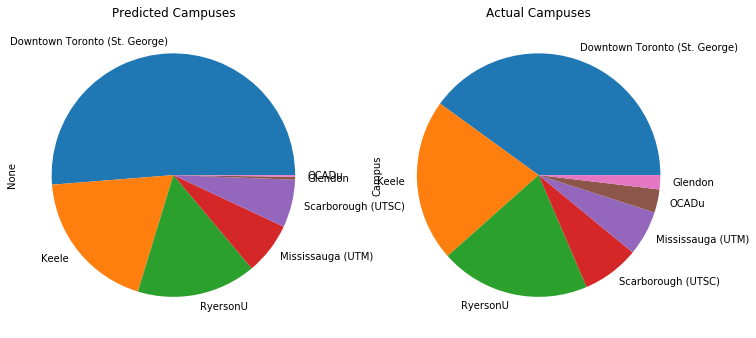

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 12))
plt.tight_layout()
plt.subplot(1, 2, 1)
pd.Series(y_pred).value_counts().plot.pie()
plt.title("Predicted Campuses")
plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().plot.pie()
plt.title("Actual Campuses")
plt.show()

In [41]:
probs = rf.predict_proba(X_test)
schools = list(rf.classes_)
results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
results.apply(lambda x: x[schools.index(x.Campus)], axis=1).mean()

0.40555504185540076

In [151]:
#import pickle
#pickle.dump(rf, open('Location_Choice_Model', 'wb'))

# To open:
# model = pickle.load(open(filename, 'rb'))